# Introduction

The metrics to be considered are:

- CPU usage
- Memory
- Disk reads (bytes/second)
- Network read (/second)
- Network write (/second)
- Disk write (byte/second)

# Data simulation

Simulating data using a simple _random walk_:

In [2]:
import random
import numpy as np
from numpy.random import multivariate_normal as mvn
from typing import List

random.seed(23)

def mvn_random_walk(n: int, 
                    start: np.ndarray, 
                    cov: List[List[float]],
                    min_allowed:List[float],
                    max_allowed:List[float],
                    anomaly_scale=0.001,
                    anomaly_rate=0.001,
                    positive=False,
                    sticky=False) -> List[np.ndarray]:
    """Multivariate Gaussian random walk"""
    x = start
    data = np.array(x)
    for t in range(n):
        x = mvn(x.flatten(), cov, 1)

        if random.random() < anomaly_rate:
            anomaly = x * [-1,1][random.randrange(2)] * anomaly_scale
            _x = np.clip(x + anomaly, min_allowed, max_allowed)
            data = np.vstack([data, _x])
            if sticky:
                x += _x
        else:
            x = np.clip(x, min_allowed, max_allowed)
            data = np.vstack([data, x])
    return data

## Univariate

For memory, we will use a mean value of `100Mb`.
The minimum memory is `0Mb` and maximum `16000Mb`.

In [3]:
mem_mean = 100.0
mem_v = 2.0
mem_min = 0
mem_max = 16000.0

The `sticky` flag allows the anomaly to be persistent, for instance:

In [4]:
data = mvn_random_walk(n=1000,
                       start=np.array([mem_mean]),
                       cov=[[mem_v]],
                       min_allowed=[mem_min],
                       max_allowed=[mem_max],
                       anomaly_scale=0.5,
                       anomaly_rate=0.01,
                       positive=True,
                       sticky=True)

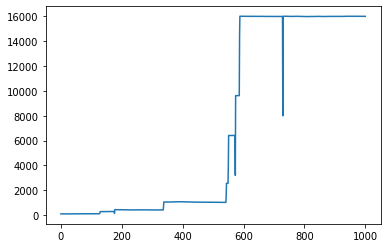

In [5]:
import matplotlib.pyplot as plt
plt.plot(data[:,0])

Otherwise, the anomaly will be temporary. For instance:

In [6]:
data = mvn_random_walk(n=1000,
                       start=np.array([mem_mean]),
                       cov=[[mem_v]],
                       min_allowed=[mem_min],
                       max_allowed=[mem_max],
                       anomaly_scale=1.5,
                       anomaly_rate=0.01,
                       positive=True,
                       sticky=False)

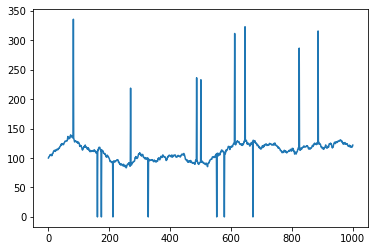

In [7]:
import matplotlib.pyplot as plt
plt.plot(data[:,0])

## Multivariate

Add another component to the data, namely a `CPU` usage (between `0%` and `100%`) and a `disk_reads` (between `0` and `5000`).

In [8]:
# CPU data parameters
cpu_mean = 1.0
cpu_v = 5.0
cpu_min = 0.0
cpu_max = 100.0

# Disk reads data parameters
dr_mean = 10.0
dr_v = 20.0
dr_min = 0.0
dr_max = 5000.0

In [9]:
data = mvn_random_walk(n=1000,
                       start=np.array([mem_mean, cpu_mean, dr_mean]),
                       cov=[[mem_v, 0, 0], [0, cpu_v, 0], [0, 0, dr_v]],
                       min_allowed=[mem_min, cpu_min, dr_min],
                       max_allowed=[mem_max, cpu_max, dr_max],
                       anomaly_scale=1.5,
                       anomaly_rate=0.01,
                       positive=True,
                       sticky=True)

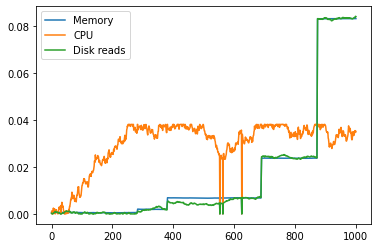

In [10]:
plt.plot(data[:,0]/np.linalg.norm(data[:,0]))
plt.plot(data[:,1]/np.linalg.norm(data[:,1]))
plt.plot(data[:,2]/np.linalg.norm(data[:,2]))
plt.legend(['Memory', 'CPU', 'Disk reads'], loc='upper left')

But we have no correlation between the variables. Let's add a correlation between `Memory` and `CPU`.

In [11]:
data = mvn_random_walk(n=1000,
                       start=np.array([mem_mean, cpu_mean, dr_mean]),
                       cov=[[mem_v, 2.0, 0], [2.0, cpu_v, 0], [0, 0, dr_v]],
                       min_allowed=[mem_min, cpu_min, dr_min],
                       max_allowed=[mem_max, cpu_max, dr_max],
                       anomaly_scale=1.5,
                       anomaly_rate=0.01,
                       positive=True,
                       sticky=True)

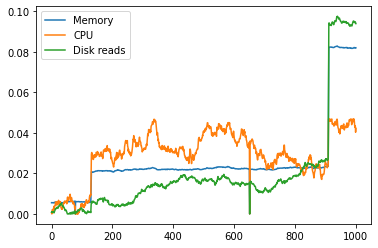

In [12]:
plt.plot(data[:,0]/np.linalg.norm(data[:,0]))
plt.plot(data[:,1]/np.linalg.norm(data[:,1]))
plt.plot(data[:,2]/np.linalg.norm(data[:,2]))
plt.legend(['Memory', 'CPU', 'Disk reads'], loc='upper left')

# CUSUM

In [13]:
import numpy as np
def CUSUM(data, cold=100, threshold_t=5):
    S_high = 0
    S_low = 0
    n = len(data)
    chart = []
    
    for i in range(n):
        if i < cold:
            chart.append((False, S_high, S_low,))
            continue

        mean, std = np.mean(data[:i]), np.std(data[:i])
        Z_o = data[i] - mean - std
        S_high_ = max(0, S_high + Z_o)
        S_low = max(0, S_low - Z_o)
        d = threshold_t * std
        if S_high_ > d:
            chart.append((True, S_high_, S_low))
        else:
            S_high = S_high_
            chart.append((False, S_high, S_low))
    return chart

In [14]:
memory_cusum = CUSUM(data[:,0])
cpu_cusum = CUSUM(data[:,1])
dr_cusum = CUSUM(data[:,2])

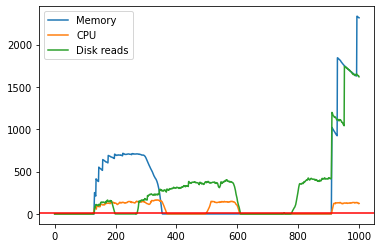

In [15]:
plt.plot([S[1] for S in memory_cusum])
plt.plot([S[1] for S in cpu_cusum])
plt.plot([S[1] for S in dr_cusum])
plt.legend(['Memory', 'CPU', 'Disk reads'], loc='upper left')
plt.axhline(y = 5, color = 'r', linestyle = '-')

# Train anomaly model

In [25]:
import pandas as pd

df = pd.DataFrame()
df['memory'] = data[:,0]
df['cpu'] = data[:,1]
df['dr'] = data[:,2]
df.head()

,memory,cpu,dr
0,100.000000,1.000000,10.000000
1,98.691736,0.000000,8.647039
2,100.555756,2.529534,12.916203
3,100.231124,4.695998,10.347713
4,100.308298,2.302335,10.979661


In [28]:
df['memory_anomaly'] = [1 if S[0] else 0 for S in memory_cusum]
df['cpu_anomaly'] = [1 if S[0] else 0 for S in cpu_cusum]
df['dr_anomaly'] = [1 if S[0] else 0 for S in dr_cusum]
df.head()

,memory,cpu,dr,memory_anomaly,cpu_anomaly,dr_anomaly
0,100.000000,1.000000,10.000000,0,0,0
1,98.691736,0.000000,8.647039,0,0,0
2,100.555756,2.529534,12.916203,0,0,0
3,100.231124,4.695998,10.347713,0,0,0
4,100.308298,2.302335,10.979661,0,0,0


In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=23)

In [32]:
X = df[['memory', 'cpu', 'dr']]
X.head()

,memory,cpu,dr
0,100.000000,1.000000,10.000000
1,98.691736,0.000000,8.647039
2,100.555756,2.529534,12.916203
3,100.231124,4.695998,10.347713
4,100.308298,2.302335,10.979661


In [31]:
y = df[['memory_anomaly', 'cpu_anomaly', 'dr_anomaly']]
y.head()

,memory_anomaly,cpu_anomaly,dr_anomaly
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [33]:
clf.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=23)

Generate a new dataset

In [34]:
data_test = mvn_random_walk(n=1000,
                       start=np.array([mem_mean, cpu_mean, dr_mean]),
                       cov=[[mem_v, 2.0, 0], [2.0, cpu_v, 0], [0, 0, dr_v]],
                       min_allowed=[mem_min, cpu_min, dr_min],
                       max_allowed=[mem_max, cpu_max, dr_max],
                       anomaly_scale=1.5,
                       anomaly_rate=0.01,
                       positive=True,
                       sticky=True)

array([[1.00000000e+02, 1.00000000e+00, 1.00000000e+01],
       [1.01776418e+02, 1.43155816e+00, 7.73331761e+00],
       [9.98680099e+01, 3.53636003e-01, 1.05915828e+01],
       ...,
       [1.59967295e+04, 8.91110911e+01, 4.94197460e+03],
       [1.59994039e+04, 8.93503480e+01, 4.94176642e+03],
       [1.60000000e+04, 9.19518434e+01, 4.94409606e+03]])

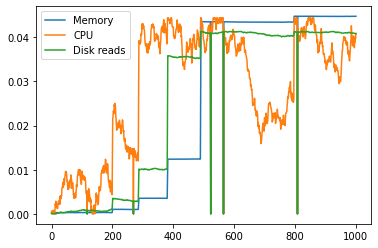

In [37]:
plt.plot(data_test[:,0]/np.linalg.norm(data_test[:,0]))
plt.plot(data_test[:,1]/np.linalg.norm(data_test[:,1]))
plt.plot(data_test[:,2]/np.linalg.norm(data_test[:,2]))
plt.legend(['Memory', 'CPU', 'Disk reads'], loc='upper left')

In [40]:
predictions = clf.predict(data_test)

/Users/rui/.virtualenvs/shi-models/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [41]:
df_test = pd.DataFrame()
df_test['memory'] = data_test[:,0]
df_test['cpu'] = data_test[:,1]
df_test['dr'] = data_test[:,2]
df_test.head()

,memory,cpu,dr
0,100.000000,1.000000,10.000000
1,101.776418,1.431558,7.733318
2,99.868010,0.353636,10.591583
3,98.438118,0.000000,11.063285
4,95.270876,0.000000,5.454813


In [42]:
df_test['memory_anomaly'] = predictions[:,0]
df_test['cpu_anomaly'] = predictions[:,1]
df_test['dr_anomaly'] = predictions[:,2]
df_test.head()

,memory,cpu,dr,memory_anomaly,cpu_anomaly,dr_anomaly
0,100.000000,1.000000,10.000000,0,0,0
1,101.776418,1.431558,7.733318,0,0,0
2,99.868010,0.353636,10.591583,0,0,0
3,98.438118,0.000000,11.063285,0,0,0
4,95.270876,0.000000,5.454813,0,0,0


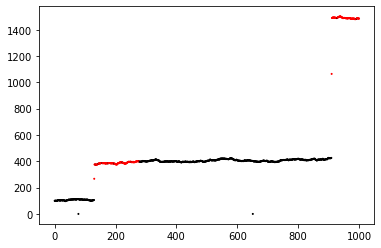

In [52]:
plt.scatter(x=range(len(df['memory'])), y=df['memory'], c=list(df['memory_anomaly'].map({0: 'black', 1: 'red'})), s=1)

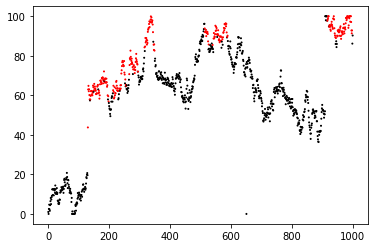

In [53]:
plt.scatter(x=range(len(df['cpu'])), y=df['cpu'], c=list(df['cpu_anomaly'].map({0: 'black', 1: 'red'})), s=1)

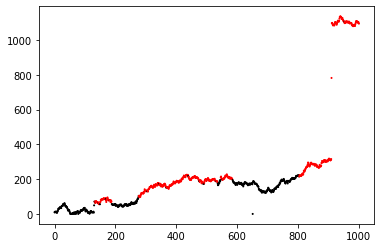

In [54]:
plt.scatter(x=range(len(df['dr'])), y=df['dr'], c=list(df['dr_anomaly'].map({0: 'black', 1: 'red'})), s=1)